# Create model arquitecture

In [123]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import random
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)


tf.keras.backend.set_floatx('float32')

In [125]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [126]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot
    return r2

In [127]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float32)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [128]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))
    
    feature_columns.append(set_one_hot_feature('vehicleType', data))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    feature_columns.append(set_one_hot_feature('model', data))
    
    
    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [129]:
train = preprocessing_fn(
    path='data/train.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)
val = preprocessing_fn(
    path='data/val.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)
test = preprocessing_fn(
    path='data/test.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)


print(train.shape)
print(val.shape)
print(test.shape)

(75362, 9)
(18841, 9)
(40373, 9)


In [130]:
train.dtypes

price                   int64
yearOfRegistration    float32
model                  object
kilometer             float32
powerPS               float32
abtest                 object
fuelType               object
vehicleType            object
gearbox                object
dtype: object

In [131]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)
test_ds = df_to_dataset(dataframe=test, target_name='price', shuffle=True, batch_size=512)

In [132]:
feature_layer = feature_columns(train, train_ds)

Epoch 1/100
148/148 [==============================] - 2s 12ms/step - loss: 2987.9536 - mean_absolute_error: 2987.9536 - mean_squared_error: 29142918.0000 - val_loss: 1333.7759 - val_mean_absolute_error: 1333.7759 - val_mean_squared_error: 6676612.5000
Epoch 2/100
148/148 [==============================] - 1s 9ms/step - loss: 1339.0449 - mean_absolute_error: 1339.0449 - mean_squared_error: 12556897.0000 - val_loss: 1126.9423 - val_mean_absolute_error: 1126.9423 - val_mean_squared_error: 4798393.5000
Epoch 3/100
148/148 [==============================] - 1s 9ms/step - loss: 1262.6870 - mean_absolute_error: 1262.6870 - mean_squared_error: 11096662.0000 - val_loss: 1100.4099 - val_mean_absolute_error: 1100.4099 - val_mean_squared_error: 4352702.5000
Epoch 4/100
148/148 [==============================] - 1s 9ms/step - loss: 1217.5922 - mean_absolute_error: 1217.5922 - mean_squared_error: 8802586.0000 - val_loss: 1057.0946 - val_mean_absolute_error: 1057.0946 - val_mean_squared_error: 40900

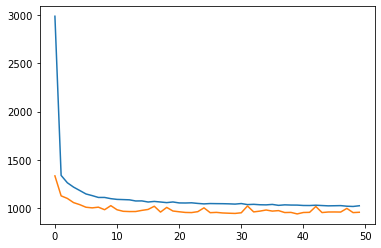

In [152]:
dp_rate = 0.1
lr = 0.001
hu = 60
momentum = 0.9

model = keras.Sequential([
    feature_layer,
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    #layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)
plt.show()

In [153]:
hist.tail(10)

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
40,1027.280273,1027.280273,3657520.00,954.605835,954.605835,3190437.00,40
41,1026.829102,1026.829102,3666025.25,956.222290,956.222290,3156507.00,41
42,1029.979858,1029.979858,3839338.00,1016.846985,1016.846985,3452630.25,42
43,1026.597290,1026.597290,3637431.25,954.025391,954.025391,3162250.75,43
44,1023.545898,1023.545898,3586134.75,959.680359,959.680359,3179172.50,44
45,1024.566895,1024.566895,3619680.25,960.079102,960.079102,3183965.50,45
46,1025.902588,1025.902588,3685817.00,959.099304,959.099304,3190182.25,46
47,1019.726257,1019.726257,3625288.75,996.990479,996.990479,3382309.75,47
48,1017.103699,1017.103699,3560352.25,953.572083,953.572083,3150623.25,48
49,1024.411987,1024.411987,3671472.50,956.943481,956.943481,3207332.25,49


In [154]:
# Validation results
print('VALIDATION RESULTS\n')
val_pred = model.predict(df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)).flatten()

val['price_pred'] = val_pred
val['abs_error'] = abs(val.price_pred - val.price)
val['error'] = val.price_pred - val.price

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(val.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(val.price - val_pred))))

# r squared
print('model r2: ' + str(r2_score(val.price, val.price_pred)))

VALIDATION RESULTS

baseline abs error: 3691.191067292686
model abs error: 956.9435656460333
model r2: 0.8866790795971994


In [155]:
# Test results
print('TEST RESULTS\n')
test_pred = model.predict(df_to_dataset(dataframe=test, target_name='price', shuffle=False, batch_size=1000)).flatten()

test['price_pred'] = test_pred
test['abs_error'] = abs(test.price_pred - test.price)
test['error'] = test.price_pred - test.price

worst_predictions = test.copy().loc[test.abs_error >= test.abs_error.quantile(0.9)]

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(test.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(test.price - test_pred))))

# r squared
print('model r2: ' + str(r2_score(test.price, test.price_pred)))

TEST RESULTS

baseline abs error: 3692.705867953832
model abs error: 953.6366626160395
model r2: 0.8818720570634165


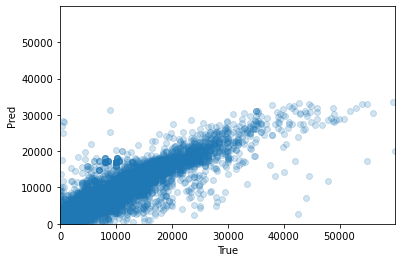

In [137]:
plt.scatter(test.price, test_pred, alpha=0.2)
plt.xlim([0, test.price.max()])
plt.ylim([0, test.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

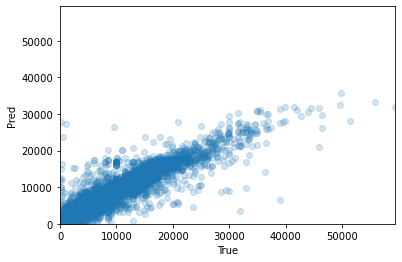

In [138]:
plt.scatter(val.price, val_pred, alpha=0.2)
plt.xlim([0, val.price.max()])
plt.ylim([0, val.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

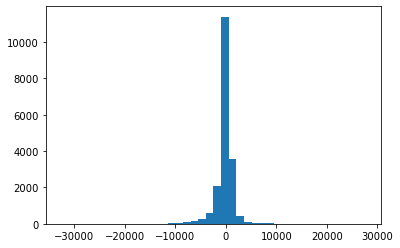

In [139]:
plt.hist(val.error, bins=40)
plt.show()

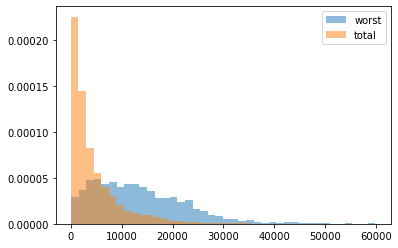

In [140]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(val.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

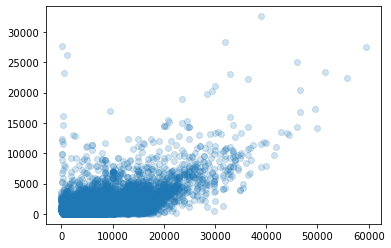

In [141]:
plt.scatter(val.price, val.abs_error, alpha=0.2)
plt.show()

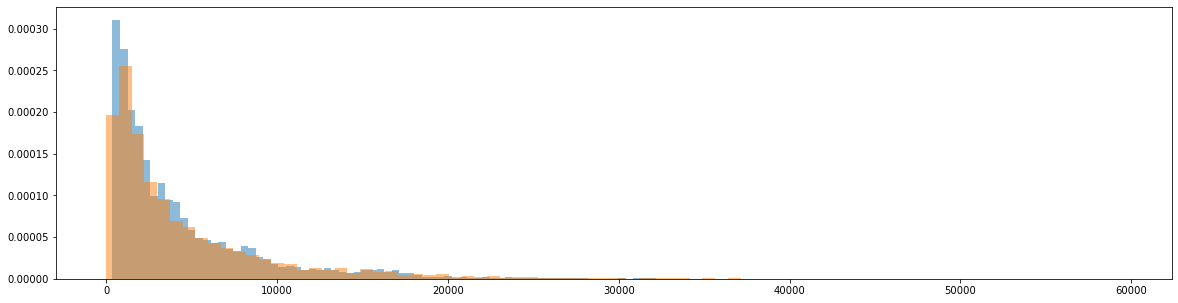

In [142]:
plt.figure(figsize=(20,5))
plt.hist(val.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(val.price, bins=80, alpha=0.5, density=True)
plt.show()

In [143]:
test.price.max()

59900

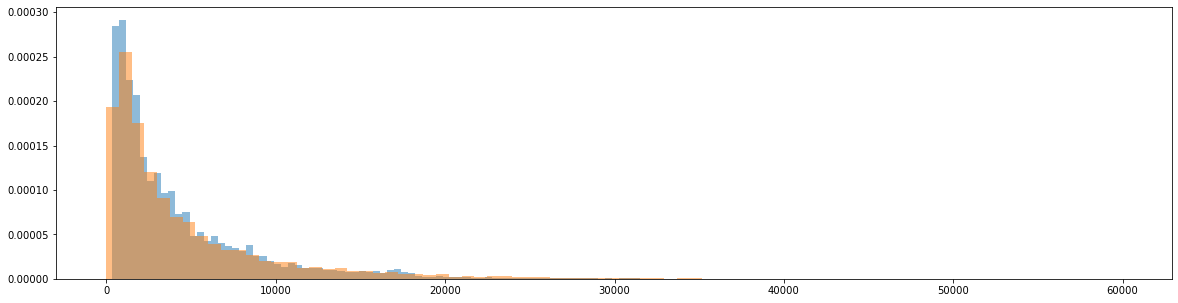

In [144]:
plt.figure(figsize=(20,5))
plt.hist(test.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(test.price, bins=80, alpha=0.5, density=True)
plt.show()